In [63]:
import pandas as pd
import numpy as np
from datetime import date, datetime
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import ast
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold, GroupKFold, train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, classification_report, roc_auc_score, confusion_matrix
%matplotlib inline

### Define NLTK stopwords

In [64]:
stopword = stopwords.words('english')

### Import Data

In [65]:
austin_calendar = pd.read_csv('Data/Austin/calendar.csv')
austin_listings = pd.read_csv('Data/Austin/listings.csv')
austin_reviews = pd.read_csv('Data/Austin/reviews.csv')

In [66]:
austin_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,326172,2020-11-07,f,$95.00,$95.00,29.0,1125.0
1,329306,2020-11-07,f,$75.00,$75.00,2.0,1125.0
2,329306,2020-11-08,f,$75.00,$75.00,2.0,1125.0
3,329306,2020-11-09,f,$75.00,$75.00,2.0,1125.0
4,329306,2020-11-10,f,$75.00,$75.00,2.0,1125.0


In [67]:
austin_listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2265,https://www.airbnb.com/rooms/2265,20201107131938,2020-11-07,Zen-East in the Heart of Austin (monthly rental),Zen East is situated in a vibrant & diverse mu...,NaN,https://a0.muscache.com/pictures/4740524/63f82...,2466,https://www.airbnb.com/users/show/2466,...,10.0,8.0,9.0,NaN,f,3,2,1,0,0.17
1,5245,https://www.airbnb.com/rooms/5245,20201107131938,2020-11-07,"Eco friendly, Colorful, Clean, Cozy monthly share",Situated in a vibrant & diverse multicultural ...,NaN,https://a0.muscache.com/pictures/5167505/b33b5...,2466,https://www.airbnb.com/users/show/2466,...,9.0,10.0,9.0,NaN,f,3,2,1,0,0.06
2,5456,https://www.airbnb.com/rooms/5456,20201107131938,2020-11-07,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,My neighborhood is ideally located if you want...,https://a0.muscache.com/pictures/14084884/b5a3...,8028,https://www.airbnb.com/users/show/8028,...,10.0,10.0,10.0,NaN,f,1,1,0,0,3.78
3,5636,https://www.airbnb.com/rooms/5636,20201107131938,2020-11-07,"Soco, Barton Springs Private Guest Cottage",MONTHLY Short Term <br />Located in the awesom...,This area is one of the top areas in Austin to...,https://a0.muscache.com/pictures/17705/ef0b703...,7148,https://www.airbnb.com/users/show/7148,...,10.0,10.0,9.0,NaN,t,2,2,0,0,0.14
4,5769,https://www.airbnb.com/rooms/5769,20201107131938,2020-11-07,NW Austin Room,<b>The space</b><br />Looking for a comfortabl...,Quiet neighborhood with lots of trees and good...,https://a0.muscache.com/pictures/23822033/ac94...,8186,https://www.airbnb.com/users/show/8186,...,10.0,10.0,10.0,NaN,f,1,0,1,0,2.00


In [68]:
austin_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2265,963,2009-03-17,7538,Niall,I stayed here during SXSW and had a really ple...
1,2265,1057,2009-03-22,10029,Michael,"Great place, close enough to everything downto..."
2,2265,200418,2011-03-16,61677,Gustaf,We had a great time in Austin staying at Paddy...
3,2265,1001630,2012-03-15,1523753,Noah,We had a great stay at Zen East for South By S...
4,2265,1016390,2012-03-19,1547660,Melissa,I arrived late in the evening so did not meet ...


### Clean calendar data

In [5]:
# Convert price/adjusted_price to numeric columns
austin_calendar.price = austin_calendar.price.str.replace('$','')
austin_calendar.adjusted_price = austin_calendar.adjusted_price.str.replace('$','')
austin_calendar.price = pd.to_numeric(austin_calendar.price.str.replace(',',''))
austin_calendar.adjusted_price = pd.to_numeric(austin_calendar.adjusted_price.str.replace(',',''))

# replace t and f with True and False
austin_calendar.replace('t', True, inplace=True)
austin_calendar.replace('f', False, inplace=True)

### Clean listing data

In [6]:
# remove columns with all NA
austin_listings = austin_listings.dropna(axis=1, how='all')

# drop columns with zero variability
nunique = austin_listings.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
austin_listings = austin_listings.drop(cols_to_drop, axis=1)

# convert price to numeric
austin_listings.price = austin_listings.price.str.replace('$','')
austin_listings.price = pd.to_numeric(austin_listings.price.str.replace(',',''))

# convert rates to numeric
austin_listings.host_response_rate = pd.to_numeric(austin_listings.host_response_rate.str.replace('%',''))/100
austin_listings.host_acceptance_rate = pd.to_numeric(austin_listings.host_acceptance_rate.str.replace('%',''))/100

# convert id and zipcode columns to categorical columns
austin_listings.id = austin_listings.id.astype('object')
austin_listings.host_id = austin_listings.host_id.astype('object')
austin_listings.neighbourhood_cleansed = austin_listings.neighbourhood_cleansed.astype('object')
austin_listings.rename(columns={'neighbourhood_cleansed':'zipcode'}, inplace=True)

# create new zipcode column
zips_to_replace = austin_listings.zipcode.value_counts().index[austin_listings.zipcode.value_counts() < 100].tolist()
austin_listings['zipcode2'] = austin_listings.zipcode.replace(to_replace=zips_to_replace, value='Other')

# remove url & last scraped columns
url_cols = austin_listings.filter(regex='url|last_scraped').columns
austin_listings = austin_listings.drop(url_cols, axis=1)

# replace t and f with True and False
austin_listings.replace('t', True, inplace=True)
austin_listings.replace('f', False, inplace=True)

# rename columns
austin_listings.rename(columns={'id':'listing_id'}, inplace=True)

### Feature Engineering

I created 

#### Convert latitude/longitude into distance metric

In [8]:
austin_listings['downtown_latitude'] = 30.2729
austin_listings['downtown_longitude'] = -97.7444

In [9]:
def lat_long_to_miles(lat1, long1, lat2, long2):
    """Return distance in miles between two points, given latitude/longitude."""
    lat1 = lat1/(180/np.pi)
    long1 = long1/(180/np.pi)
    lat2 = lat2/(180/np.pi)
    long2 = long2/(180/np.pi)
    d = 3963.0 * np.arccos((np.sin(lat1) * np.sin(lat2)) + np.cos(lat1) * np.cos(lat2) * np.cos(long2 - long1))
    return d
lat_long_distance = np.vectorize(lat_long_distance)

In [10]:
austin_listings['dist_from_downtown'] = lat_long_to_miles(austin_listings.latitude, austin_listings.longitude, 
                                                          austin_listings.downtown_latitude, austin_listings.downtown_longitude)

In [11]:
lat_long_cols = austin_listings.filter(regex='latitude|longitude').columns
austin_listings = austin_listings.drop(lat_long_cols, axis=1)

#### Years as host

In [12]:
austin_listings['today'] = datetime.today()
austin_listings['host_since'] = pd.to_datetime(austin_listings.host_since)
austin_listings['host_yrs'] = (austin_listings.today-austin_listings.host_since)
austin_listings['host_yrs'] = austin_listings['host_yrs'].apply(lambda x: x.days)/365
austin_listings['host_yrs_cat'] = pd.cut(austin_listings.host_yrs, bins=[0,3,5,7,9,11,13])

#### Host Multi-listing

In [13]:
austin_listings['Multi_listing'] = [True if x > 1 else False for x in austin_listings.calculated_host_listings_count]

#### Number of words in listing description

In [69]:
def process_text(text, stopword):
    """Return list of tokenized words with stopwords removed."""
    text = word_tokenize(str(text).lower())
    text = [word for word in text if word not in stopword and word.isalpha()]
    return text

In [15]:
austin_listings['description_length'] = austin_listings.description.apply(process_text, stopword = stopword).apply(list).apply(len)
austin_listings['neighborhood_overview_length'] = austin_listings.neighborhood_overview.apply(process_text, stopword = stopword).apply(list).apply(len)
austin_listings['amenities_length'] = austin_listings.amenities.apply(ast.literal_eval).apply(len)

#### Listing Availability

In [16]:
# join calendar and listing data
austin_cal_list = austin_calendar.merge(austin_listings, how='inner', on='listing_id')

In [17]:
availability_perc = austin_cal_list.groupby('listing_id')['available'].mean().reset_index().rename(columns={'available':'available_perc'})
austin_cal_list = austin_cal_list.merge(availability_perc, on = 'listing_id')
austin_listings = austin_listings.merge(availability_perc, on = 'listing_id')

#### Bathrooms

In [18]:
austin_listings.bathrooms_text = austin_listings.bathrooms_text.fillna('missing')
austin_listings['shared_bath'] = [1 if x in 'shared' in x else 0 for x in austin_listings.bathrooms_text]
austin_listings['bathrooms'] = austin_listings.bathrooms_text.replace(regex=' shared baths| shared bath| baths| bath| private', value='')
austin_listings.bathrooms = austin_listings.bathrooms.replace(regex='Half-bath|Private half-bath', value='.5')
austin_listings.bathrooms = austin_listings.bathrooms.replace(regex='missing', value='-1').astype('float')
austin_listings['bathrooms_cat'] = pd.cut(austin_listings.bathrooms, bins = [0,2,4,20], include_lowest=True).astype(str)
austin_listings.bathrooms_cat = austin_listings.bathrooms_cat.replace('(-0.001, 2.0]', '0-2').replace('(2.0, 4.0]', '2-4').replace('(4.0, 20.0]', '> 4')

### Basic Summary Stats

#### Room Type

In [21]:
room_type_summary = austin_listings.room_type.value_counts(normalize=True).reset_index().rename(columns={'index':'room_type','room_type':'percentage'})
room_type_summary

,room_type,percentage
0,Entire home/apt,0.779713
1,Private room,0.206603
2,Shared room,0.012440
3,Hotel room,0.001244


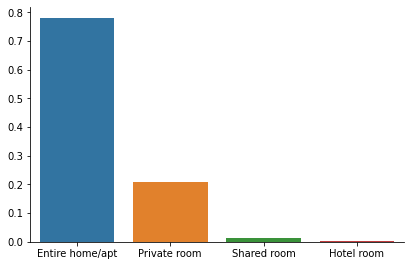

In [22]:
# listing type
g=sns.catplot(data=room_type_summary, x='room_type', y='percentage', kind='bar', height = 4, aspect=1.5)
g.set_axis_labels("", "");

#### Listing Stats

In [23]:
host_listings = austin_listings[['host_id','Multi_listing']].drop_duplicates()

In [24]:
austin_listings.Multi_listing.sum()

4763

In [25]:
listing_stats = pd.Series({'Listings':austin_listings.shape[0], 'Hosts':len(austin_listings.host_id.value_counts()),
                           'Multi-listings':np.sum(host_listings.Multi_listing)})
listing_stats = listing_stats.reset_index().rename(columns={'index':'listing',0:'N'})

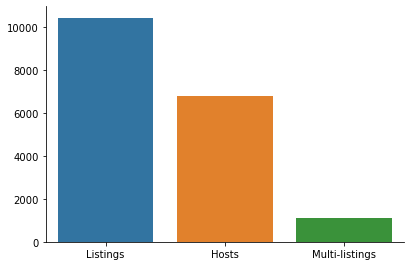

In [26]:
g=sns.catplot(data=listing_stats, x='listing', y='N', kind='bar', height=4, aspect = 1.5)
g.set_axis_labels("", "");

In [27]:
np.sum(host_listings.Multi_listing)/len(host_listings)

0.164536506537388

### Listing price by neighborhood

In [28]:
avg_price_zip_summary = austin_listings.groupby('zipcode')['price'].median().reset_index().sort_values('price', ascending=False)
avg_price_zip_summary.max()

zipcode    78759.0
price        437.0
dtype: float64

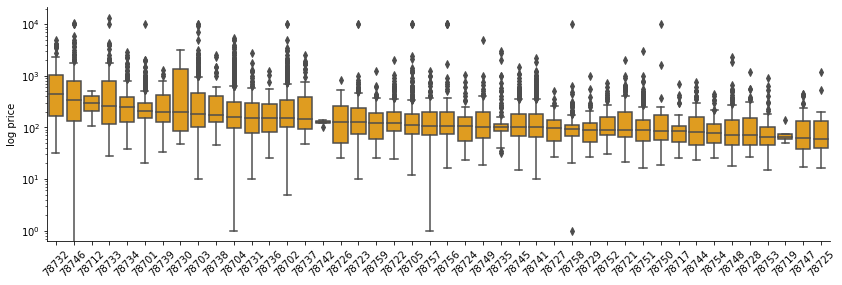

In [29]:
g = sns.catplot(data=austin_listings, x='zipcode', y='price', color='orange', kind='box', 
                order=avg_price_zip_summary.zipcode, height=4, aspect=3)
g.set_xticklabels(rotation=45)
g.set(yscale="log", xlabel='', ylabel = 'log price');

### Listing Availability

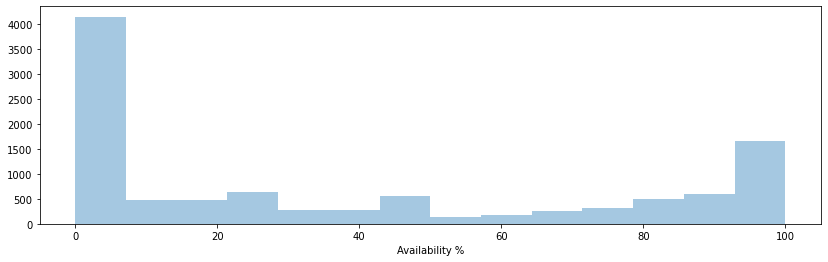

In [30]:
kwargs = {'cumulative': True}
plt.figure(figsize=(14,4)) 
fig = sns.distplot(austin_listings.available_perc*100, kde=False)
fig.set(xlabel='Availability %');

#### Hosts

In [36]:
host_data = austin_listings.filter(regex='host').drop_duplicates()

In [37]:
np.sum(host_data.host_is_superhost)/host_data.shape[0]

0.2974878801234024

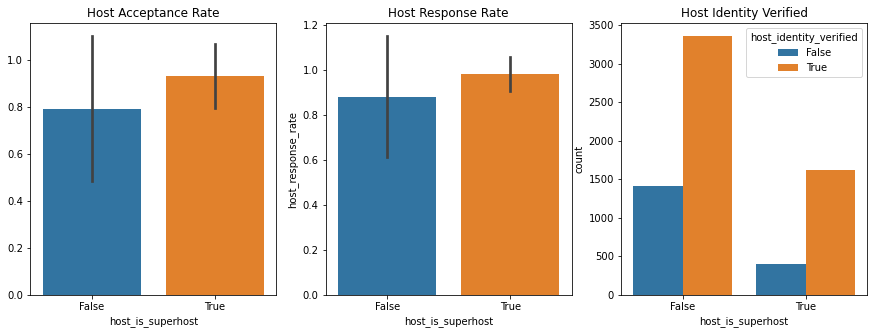

In [38]:
fig, ax = plt.subplots(1, 3, sharey=False, figsize=(15,5))
sns.barplot(data=host_data, x='host_is_superhost', y='host_acceptance_rate', ci='sd', ax=ax[0])
sns.barplot(data=host_data, x='host_is_superhost', y='host_response_rate', ci='sd', ax=ax[1])
sns.countplot(data=host_data, x='host_is_superhost', hue='host_identity_verified', ax=ax[2])
ax[0].set_title('Host Acceptance Rate')
ax[1].set_title('Host Response Rate')
ax[2].set_title('Host Identity Verified')
ax[0].set(ylabel='');

In [39]:
room_host = austin_listings.groupby('room_type')['host_is_superhost'].value_counts(normalize=True).rename('percentage').reset_index()
room_host = room_host[room_host.room_type != 'Hotel room']
room_host

,room_type,host_is_superhost,percentage
0,Entire home/apt,False,0.606433
1,Entire home/apt,True,0.393567
4,Private room,False,0.743744
5,Private room,True,0.256256
6,Shared room,False,0.961538
7,Shared room,True,0.038462


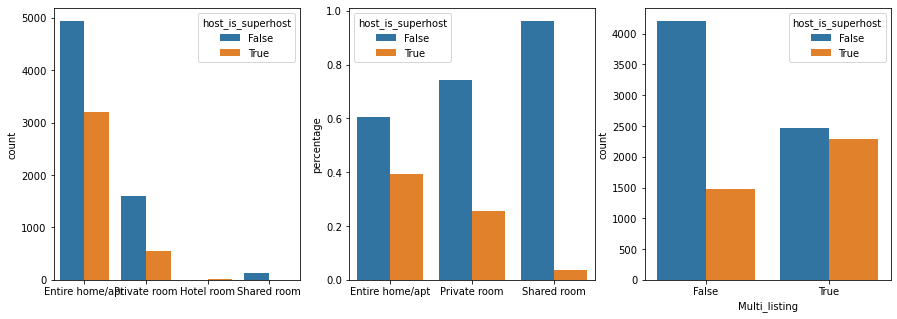

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
sns.countplot(data=austin_listings, x='room_type', hue='host_is_superhost', ax=ax[0])
sns.barplot(data=room_host, x='room_type', y='percentage', hue='host_is_superhost', ax=ax[1])
sns.countplot(data=austin_listings, x='Multi_listing', hue='host_is_superhost');
ax[0].set(xlabel='')
ax[1].set(xlabel='');

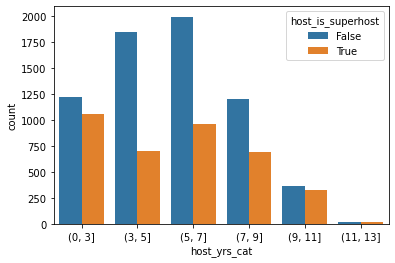

In [41]:
sns.countplot(data=austin_listings, x='host_yrs_cat', hue='host_is_superhost');

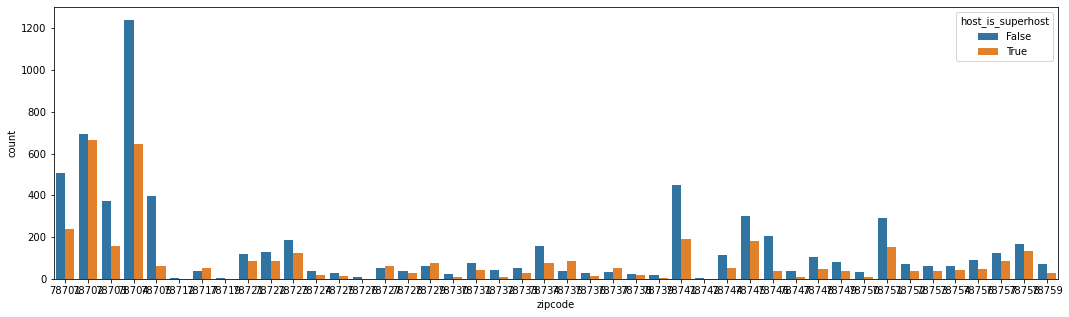

In [42]:
plt.subplots(1, 1, figsize=(18,5))
sns.countplot(data=austin_listings, x='zipcode', hue='host_is_superhost');

### Can we predict whether a host is a superhost?

In [43]:
#regex_arg = 'host|price|minimum|maximum|available|room_type|accommodates|bath|bed|review|calculated|dist|Multi|length'
regex_arg = 'host|price|minimum|maximum|available|room_type|accommodates|bath|bed|calculated|dist|Multi|length'
host_cols = austin_listings.filter(regex=regex_arg).columns.tolist()

In [44]:
host_cols_remove = ['host_name', 'host_since', 'host_location', 'host_about','host_verifications','minimum_minimum_nights',
                    'maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
                    'maximum_nights_avg_ntm','host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 
                    'bathrooms_text', 'bathrooms', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 
                    'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 
                    'calculated_host_listings_count_shared_rooms']
host_cols = [x for x in host_cols if x not in host_cols_remove]

In [45]:
host_data = austin_listings.filter(host_cols)

In [46]:
host_data = host_data.dropna(subset=['host_is_superhost'])

In [47]:
# get dummy variables
host_data_dummy = pd.get_dummies(host_data, drop_first=True, dummy_na=True)

In [48]:
# drop columns with zero/low variability
cols_to_drop = host_data_dummy.var()[host_data_dummy.std() < .1].index.tolist()
host_data_dummy = host_data_dummy.drop(columns=cols_to_drop)

In [49]:
#convert dummy cols to bool
cols_to_bool = host_data_dummy.dtypes[host_data_dummy.dtypes == 'uint8'].index.tolist()
host_data_dummy[cols_to_bool] = host_data_dummy[cols_to_bool].astype('bool')
bool_cols = host_data_dummy.dtypes[host_data_dummy.dtypes == 'bool'].index.tolist()

### SKLearn

In [50]:
host_data_dummy2 = host_data_dummy.groupby('host_id').mean().reset_index()
host_data_dummy2 = host_data_dummy2.drop(columns=['host_id'])
host_data_dummy2[bool_cols] = host_data_dummy2[bool_cols].astype('bool')
num_index = [i for i, val in enumerate(host_data_dummy2.dtypes != 'bool') if val] 

In [51]:
host_data_dummy2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6804 entries, 0 to 6803
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   host_response_rate                     3090 non-null   float64
 1   host_acceptance_rate                   3843 non-null   float64
 2   accommodates                           6804 non-null   float64
 3   bedrooms                               6440 non-null   float64
 4   beds                                   6762 non-null   float64
 5   price                                  6804 non-null   float64
 6   minimum_nights                         6804 non-null   float64
 7   maximum_nights                         6804 non-null   float64
 8   calculated_host_listings_count         6804 non-null   float64
 9   dist_from_downtown                     6804 non-null   float64
 10  host_yrs                               6804 non-null   float64
 11  Mult

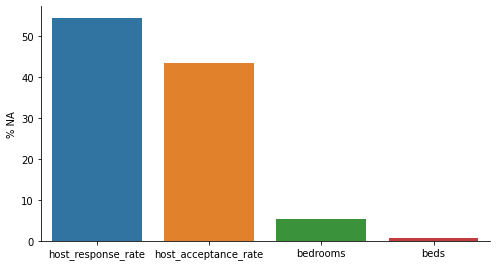

In [52]:
na_percent = (host_data_dummy2.isnull().sum()/host_data_dummy2.shape[0]).reset_index()
na_percent = na_percent.rename(columns={'index':'predictor',0:'percent'}).sort_values('percent', ascending=False)
na_percent['percent'] = na_percent.percent*100
g=sns.catplot(data=na_percent[na_percent.percent > 0], x='predictor', y='percent', kind='bar', height = 4, aspect=1.75)
g.set(xlabel = '', ylabel='% NA');

In [53]:
X_df = host_data_dummy2.drop(columns=['host_is_superhost_True'])
X = X_df.to_numpy()
y = host_data_dummy2['host_is_superhost_True'].to_numpy()

### Logistic Regression with 5-fold CV

In [54]:
imp = IterativeImputer(max_iter=100, random_state=0)

In [55]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)
class_report = []
auc = []
conf_mat = []
for train_index, test_index in kf.split(X):
    # split into training and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # fit multivariate imputation on training data
    imp.fit(X_train)
    
    # impute missing values on training data
    X_train = imp.transform(X_train)
    
    # impute missing values on test data
    X_test = imp.transform(X_test)
    
    # Random Forest model
    rfor_reg = RandomForestClassifier(random_state=0).fit(X_train, y_train)
    y_pred = rfor_reg.predict(X_test)
    y_pred_probs = rfor_reg.predict_proba(X_test)[:,1]
    class_report.append(classification_report(y_test, y_pred, output_dict=True))
    conf_mat.append(confusion_matrix(y_test, y_pred))
    auc.append(roc_auc_score(y_test, y_pred_probs))

In [56]:
accuracy = [class_report[x]['accuracy'] for x in range(len(class_report))]
precision = [class_report[x]['True']['precision'] for x in range(len(class_report))]
recall = [class_report[x]['True']['recall'] for x in range(len(class_report))]
f1 = [class_report[x]['True']['f1-score'] for x in range(len(class_report))]

In [57]:
np.mean(accuracy)

0.8153959026667243

In [58]:
np.mean(auc)

0.8873997759883372

In [59]:
# fit final model on all training data
imp.fit(X)
X_new = imp.transform(X)
rfor_reg = RandomForestClassifier(max_features='sqrt',random_state=0).fit(X_new, y)

In [60]:
ranked_idx = (-rfor_reg.feature_importances_).argsort()

In [61]:
ranked_predictors = pd.DataFrame(rfor_reg.feature_importances_[ranked_idx].reshape(1,29), columns=X_df.iloc[:,ranked_idx].columns)
ranked_predictors = ranked_predictors.transpose().reset_index().rename(columns={'index':'predictor',0:'importance'})

### Top Predictors

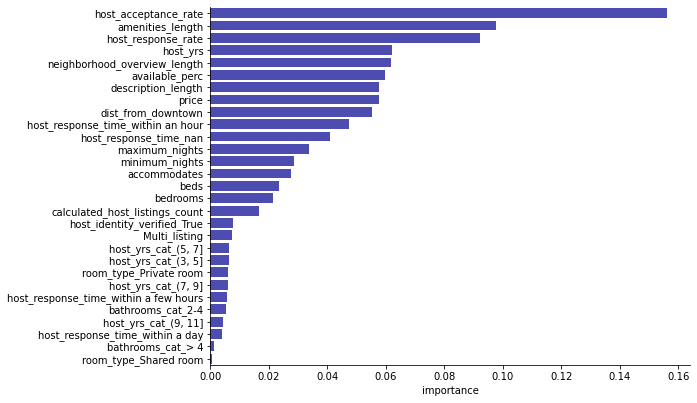

In [62]:
g=sns.catplot(data=ranked_predictors, x='importance', y='predictor', kind='bar', color='#3c3cc2', height= 5.7, aspect=1.75)
g.set(ylabel = '');

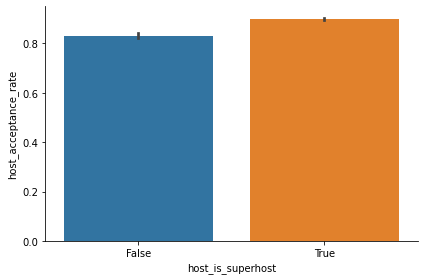

In [86]:
g=sns.catplot(data=host_data, x='host_is_superhost', y='host_acceptance_rate', kind='bar', height = 4, aspect = 1.5);

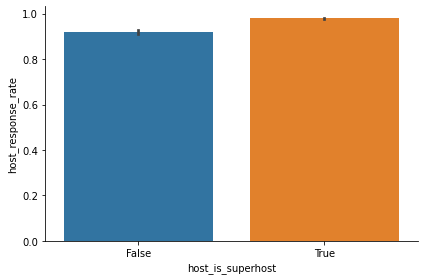

In [87]:
g=sns.catplot(data=host_data, x='host_is_superhost', y='host_response_rate', kind='bar', height = 4, aspect = 1.5);

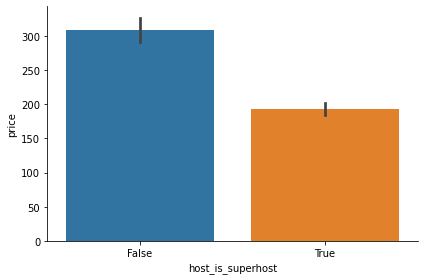

In [88]:
g=sns.catplot(data=host_data, x='host_is_superhost', y='price', kind='bar', height = 4, aspect = 1.5);

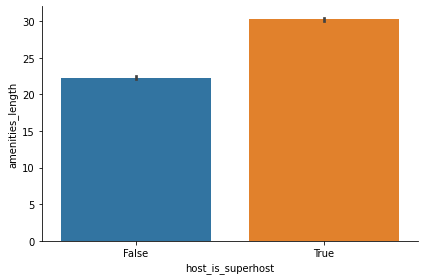

In [89]:
g=sns.catplot(data=host_data, x='host_is_superhost', y='amenities_length', kind='bar', height = 4, aspect = 1.5);

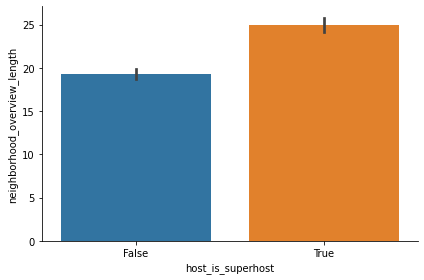

In [90]:
g=sns.catplot(data=host_data, x='host_is_superhost', y='neighborhood_overview_length', kind='bar', height = 4, aspect = 1.5);

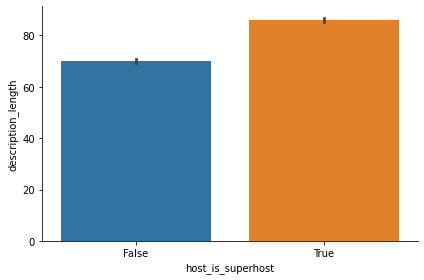

In [91]:
g=sns.catplot(data=host_data, x='host_is_superhost', y='description_length', kind='bar', height = 4, aspect = 1.5);